# 目的：kerasで深層学習のmodel作成の仕方を学ぶついでにいろいろなアルゴリズムを試そう

物体認識の主な流れ　　　
1. Region Proposal : 物体らしい箇所を検出  
2. Classification : 検出箇所のラベル分類  
3. Bounding Box Regression : 正確な物体を囲う位置座標を回帰   


* *R-CNN (CVPR2014)* ① によって得られた領域から特徴抽出する為に) CNNを用いた物体検出アルゴリズムのベースを提案	
    物体領域候補の重複による計算の冗長性 / ① には既存手法5、② ③ にはSVMを用いている
    Ad hoc training objectives (② ③ の学習および CNN の fine-tune を個別に行う必要がある)
* *SPPnet(ECCV2014)* spatial pyramid pooling layer の提案によってR-CNNにおける計算の冗長性を解消	
     ベースがR-CNNなので学習が ad hoc なのは変わらず
* *Fast R-CNN (ICCV2015)* ② と ③ を同時に学習する multi-task learning を用いた手法の提案 (ad hoc な学習からの脱却)	
     ① は既存手法を用いているため、冗長な検出が多い
* *Faster R-CNN (NIPS2015)* ① もCNNで行うことで End to End な学習を可能とする手法の提案	
    これまでの手法より高速だが Real-Time な検出が行えない (5 FPS)
* *YOLO(CVPR2015)* 画像をグリッドに分割して各領域ごとに ② ③ を行う別アプローチを提案 ( ① の排除) 
    1つのシンプルなネットワークで構築 
    45-155 FPS での Real-Time な検出速度を達成	
    アルゴリズムの制約上、画像内に多オブジェクトがある場合の検出は困難
* *SSD(ECCV2016)* YOLOと同じく ① を排除したシンプルなネットワークによる手法の提案   
    多オブジェクトの検出に比較的強くYOLOより高速	
    恣意的なパラメータがまだ多い (Choosing scales and aspect ratios for default boxes, Hard negative mining, Data augmentation)
* *YOLOv2* (arXiv2016) ResNet と SSD を組み合わせた手法より高い精度を達成  
    背景の誤検出が少ない (Recallが高い) / Batch Normalization を追加	
    YOLOベースなため相変わらず多オブジェクト検出に弱い
* *DSSD(arXiv2017)*	SSD の fine-tuneにVGGではなく(Batch Normalizationを適用させた)Residual-101を用いDeconvolution layerを追加することで検出精度を向上させた	
    Deconvolution layer を追加したことで速度は SSD より劣っている



[参考]
* CNNモデルをそれぞれ比較 : http://szdr.hatenablog.com/entry/2017/03/01/000614
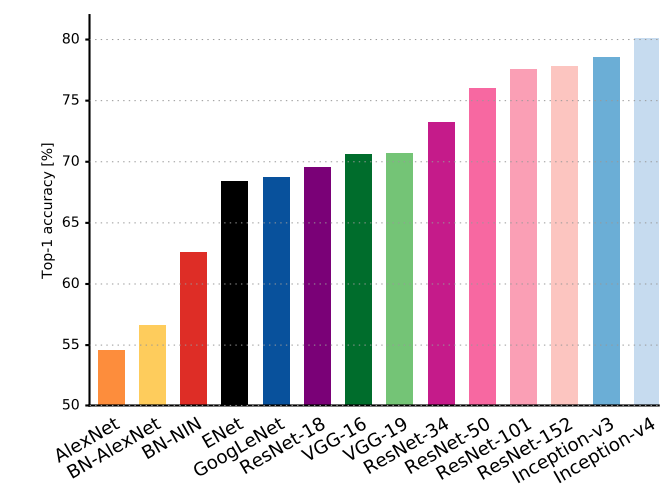  

In [ ]:
!nvidia-smi

In [1]:
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend 
from keras.models import Model
from keras.utils import np_utils
import keras.callbacks
import matplotlib.pyplot as plt

import os

Using TensorFlow backend.


今回作りたいもの  
### Cnn
### ResNet
### VGG
### Unet
### Retinanet

# 手始めにfunctionalAPIになれる   
### 全結合  

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)

In [ ]:
#画像データの前処理

##①訓練データを一次元配列に変換
##②正規化
x_train = x_train.reshape(60000, 28*28).astype('float32')/255
x_test = x_test.reshape(10000, 28*28).astype('float32')/255

##③教師データをone-hot表現
y_train = np_utils.to_categorical(y_train.astype('int32'),10)
y_test = np_utils.to_categorical(y_test.astype('int32'),10)

In [ ]:
#modelの作成 
inputs = Input(shape=(784,))

nw = Dense(512, activation='relu')(inputs)
nw = Dropout(.5)(nw)
nw = Dense(512, activation='relu')(nw)
nw = Dropout(.5)(nw)
predictions = Dense(10, activation='softmax')(nw)

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ[" CUDA_VISIBLE_DEVICES "] = "0"

# モデルの定義(インプットとレイヤーを指定)
model = Model(inputs=inputs, outputs=predictions)

# 訓練プロセスの定義
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs = 20, verbose=1,callbacks=[tb_cb],  validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
plt.subplot(2, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

### CNN

In [15]:
batch_size = 128
num_classes = 10
epochs = 10

#入力データの次元
img_rows , img_cols = 28, 28

#画像データの前処理
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

###kerasのバックエンドで使用するライブラリにより入力チャネルの順番が異なる為、条件分岐
if backend.image_data_format() == 'channels_first':
    inputs = Input(shape = (1, img_rowa, img_cols))
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols).astype('float32')/255.
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols).astype('float32')/255

else:
    inputs = Input(shape= (img_rows, img_cols, 1))
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1).astype('float32')/255.
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1).astype('float32')/255

In [16]:
#モデルの作成
### 2つの畳み込みレイヤー
conv1_1 = Conv2D(32, (3, 3), activation='relu', name='conv1_1')(inputs)
conv1_2 = Conv2D(64, (3, 3), activation='relu', name='conv1_2')(conv1_1)

### Maxplllong2D:pool_sizeの範囲で最も大きい値を次の層に渡す
pool1 = MaxPooling2D(pool_size=(2,2), name='pool1')(conv1_2)

### Dropout:訓練時に一定確率で中間層を無視する
nw = Dropout(.25)(pool1)

### Flatten:2次元データを1次元に変換
nw = Flatten()(nw)
nw = Dense(128, activation='relu')(nw)
nw = Dropout(.5)(nw)

###　最終レイヤー(10クラスに分類)
predictions = Dense(10, activation='softmax')(nw)

### モデルの作成
model = Model(inputs=inputs, outputs= predictions)
# 訓練プロセスの定義
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 26, 26, 32)        320       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 24, 24, 64)        18496     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               1179776   
__________

In [17]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ[" CUDA_VISIBLE_DEVICES "] = "0"

#訓練の実行
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1,  validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 170us/step - loss: 0.2679 - acc: 0.9171 - val_loss: 0.0564 - val_acc: 0.9809
Epoch 2/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.0875 - acc: 0.9735 - val_loss: 0.0421 - val_acc: 0.9862
Epoch 3/10
60000/60000 [==============================] - 8s 130us/step - loss: 0.0653 - acc: 0.9802 - val_loss: 0.0346 - val_acc: 0.9877
Epoch 4/10
60000/60000 [==============================] - 8s 130us/step - loss: 0.0555 - acc: 0.9833 - val_loss: 0.0310 - val_acc: 0.9891
Epoch 5/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.0464 - acc: 0.9859 - val_loss: 0.0344 - val_acc: 0.9889
Epoch 6/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.0422 - acc: 0.9871 - val_loss: 0.0324 - val_acc: 0.9898
Epoch 7/10
60000/60000 [==============================] - 8s 130us/step - loss: 0.0371 - acc: 0.9890 - val_loss: 0.0286 -

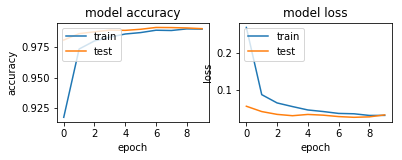

In [18]:
plt.subplot(2, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()